# File and libraries

In [ ]:
import pandas as pd
import numpy as np


filepath=r'data/df_gira_pre_proc.csv'

file_tag = "Gira Bike Station Load"


In [ ]:
%run "scripts/dslabs_functions.py"


# data functions

In [ ]:
%run "scripts/data_functions.py"

# Load

In [ ]:
# test_data=True
test_data=False

df=pd.read_csv(filepath, sep=';', decimal=".",  index_col='date', parse_dates=True,  infer_datetime_format=True)



df.info()

In [ ]:
display(df.shape)
display(df.head())

In [ ]:
series: Series = df['target_station_load_rate']


# Data Profiling

## Dataset Description

- Desc:The dataset was provided by dados.cm-lisboa. It contains open public data sources regarding diferent public sersvices and features in the district of Lisbon. This dataset contains data on the Gira bike stations load in Lisbon. It has info, by minute, of bikes available on the station, number of docs in the stations and also state (active or repair) of the station
    - link: https://dados.cm-lisboa.pt/dataset/gira-bicicletas-de-lisboa-historico
- Time scope: data for the year of 2022
- The original dataset contained data on the station load of the gira stations. To enrich the forecasting we also add information about some weather parameters in Lisbon and also holidays calendar for the period analysed.

## Dimensionality

In [ ]:
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_bar_chart

figure(figsize=(4, 2))
values: dict[str, int] = {"nr records": df.shape[0], "nr variables": df.shape[1]}
plot_bar_chart(
    list(values.keys()), list(values.values()), title=f"{file_tag} | Nr of records vs nr variables"
)
# savefig(f"{file_tag}_records_variables.png")
show()

## Missing values

In [ ]:
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_bar_chart

mv: dict[str, int] = {}
total_rows = len(df)

for var in df.columns:
    nr: int = df[var].isna().sum()
    if nr > 0:
        percentage = (nr / total_rows) * 100
        mv[var] = (nr, percentage)

sorted_mv = dict(sorted(mv.items(), key=lambda item: item[1][0], reverse=True))

variables = list(sorted_mv.keys())
missing_values = [val[0] for val in sorted_mv.values()]
percentages = [val[1] for val in sorted_mv.values()]

figure(figsize=(25, 10)) #(largura,altura) 

plot_bar_chart(
    variables,
    missing_values,
    title=f"{file_tag} Nr of missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)
for i, (var, perc) in enumerate(zip(variables, percentages)):
    text(i, missing_values[i] + max(missing_values) * 0.08, f"{perc:.1f}%", ha="center", va="center_baseline")

savefig(f"images/{file_tag}_mv.png")
show()

#### Analysis for the report

Our initial dataset, contains missing value for the target variables and also for other relveant external variables. 

### Variables Type

In [ ]:
df.dtypes

In [ ]:
import pandas as pd
from pandas import DataFrame, Series, to_numeric, to_datetime

def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": []}

    # Check if the index is a datetime type
    if isinstance(df.index, pd.DatetimeIndex):
        variable_types["date"].append("index")  # Label index separately

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c] = df[c].astype("bool")  # Convert to boolean
        else:
            # ✅ First, check if it's already datetime
            if pd.api.types.is_datetime64_any_dtype(df[c]):
                variable_types["date"].append(c)
            else:
                # ✅ Convert numeric values
                try:
                    df[c] = to_numeric(df[c], errors="raise")
                    variable_types["numeric"].append(c)
                except ValueError:
                    # ✅ Convert datetime (and store the converted values)
                    try:
                        df[c] = to_datetime(df[c], errors="raise", format="%Y-%m-%d %H:%M:%S")
                        variable_types["date"].append(c)
                    except ValueError:
                        variable_types["symbolic"].append(c)

    return variable_types

# Apply the function
variable_types = get_variable_types(df)
print(variable_types)

# Check if datetime conversion worked
print(df.dtypes)
print(df.head())

#### Change symbolic columns type, to category (instead of object)

### variables per type plot

In [ ]:
counts: dict[str, int] = {}
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])

figure(figsize=(4, 2))
plot_bar_chart(
    list(counts.keys()), list(counts.values()), title=f"{file_tag} | Nr of variables per type"
)
# savefig(f"{file_tag}_variable_types.png")
show()

## Variables Type

## Data Distribution

In [ ]:
summary5: df = df.describe(include="all")
summary5

In [ ]:

# Obter os tipos de variáveis
variables_types: dict[str, list] = get_variable_types(df)

# Debug: Verificar os tipos de variáveis
print("Tipos de variáveis:", variables_types)

### Numeric Values

#### Boxplot for All Numeric variables

In [ ]:
from matplotlib.pyplot import savefig, show, title


variables_types: dict[str, list] = get_variable_types(df)
numeric: list[str] = variable_types["numeric"]


if [] != numeric:
    df[numeric].boxplot(rot=45)
    title(f'{file_tag} - Boxplot for numeric variables')  # Correct way to set title
    savefig(f"images/{file_tag}_profiling_global_boxplot_numeric_vars.png")
    show()
else:
    print("There are no numeric variables.")

#### Boxplot for Single Variable Values

In [ ]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT
import pandas as pd

# Obter as variáveis categorizadas pela função get_variable_types
variable_types: dict[str, list] = get_variable_types(df)

# Apenas variáveis numéricas são usadas para os boxplots
numeric = variable_types.get('numeric', [])

# Verificar se a lista de variáveis numéricas não está vazia
if numeric:
    rows, cols = define_grid(len(numeric))  # Definir o número de linhas e colunas com base no número de variáveis
    fig, axs = subplots(rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False)
    fig.suptitle(f"{file_tag} - Boxplots for Numeric Variables", fontsize=16)

    # Iterar sobre as variáveis numéricas e criar os subplots
    i, j = 0, 0
    for n in numeric:
        # Garantir que apenas valores numéricos são passados para boxplot
        data = df[n].dropna().values
        
        if pd.api.types.is_numeric_dtype(df[n]):
            axs[i, j].set_title(f"Boxplot for {n}")
            axs[i, j].boxplot(data)
        
        # Mover para o próximo subplot
        i, j = (i + 1, 0) if (j + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_profiling_boxplot_single_num_vars.png")
    # Mostrar os gráficos
    show()
else:
    print("There are no numeric variables.")

#### Identify the distribuiton of each numeric variable

In [ ]:
from numpy import log
from pandas import Series
from scipy.stats import norm, expon, lognorm
from matplotlib.axes import Axes
#from dslabs_functions import plot_multiline_chart


def compute_known_distributions(x_values: list) -> dict:
    distributions = dict()
    if len(x_values) > 0:  # Check for empty list
        # Gaussian
        mean, sigma = norm.fit(x_values)
        distributions["Normal(%.1f,%.2f)" % (mean, sigma)] = norm.pdf(x_values, mean, sigma)
        # Exponential
        loc, scale = expon.fit(x_values)
        distributions["Exp(%.2f)" % (1 / scale)] = expon.pdf(x_values, loc, scale)
        # LogNorm
        sigma, loc, scale = lognorm.fit(x_values)
        distributions["LogNor(%.1f,%.2f)" % (log(scale), sigma)] = lognorm.pdf(
            x_values, sigma, loc, scale
        )
    return distributions


def histogram_with_distributions(ax: Axes, series: Series, var: str):
    values: list = series.sort_values().to_list()
    if len(values) > 0:  # Check for empty values list
        ax.hist(values, 20, density=True)
        distributions: dict = compute_known_distributions(values)
        plot_multiline_chart(
            values,
            distributions,
            ax=ax,
            title="Best fit for %s" % var,
            xlabel=var,
            ylabel="",
        )
    else:
        print(f"No data available for {var}")


if [] != numeric:
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    fig.suptitle(f'{file_tag} | Distribution histogram with best fit')
    for n in range(len(numeric)):
        histogram_with_distributions(axs[i, j], df[numeric[n]].dropna(), numeric[n])
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"./{file_tag}_histogram_numeric_distribution.png")
    show()
else:
    print("There are no numeric variables.")


## Univariate Time Series - Chart

In [ ]:
print(df.dtypes)


In [ ]:
def plot_line_chart(
    xvalues: list,
    yvalues: list,
    ax: Axes = None,  # type: ignore
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    name: str = "",
    percentage: bool = False,
    show_stdev: bool = False,
) -> Axes:
    if ax is None:
        ax = gca()
    ax = set_chart_labels(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
    ax = set_chart_xticks(xvalues, ax, percentage=percentage)
    if any(y < 0 for y in yvalues) and percentage:
            ax.set_ylim(-1.0, 1.0)
    ax.plot(xvalues, yvalues, c=LINE_COLOR, label=name)
    if show_stdev:
        stdev: float = round(std(yvalues), 3)
        y_bottom: list[float] = [(y - stdev) for y in yvalues]
        y_top: list[float] = [(y + stdev) for y in yvalues]
        ax.fill_between(xvalues, y_bottom, y_top, color=FILL_COLOR, alpha=0.2)
    return ax

In [ ]:
from pandas import  DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_line_chart, HEIGHT

target = "target_station_load_rate"
data: DataFrame = df

series: Series = df[target]
print("Nr. Records = ", series.shape[0])
print("First timestamp", series.index[0])
print("Last timestamp", series.index[-1])

HEIGHT=4
figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} - hourly {target}")
show()


#### Analysis for the report

## Multivariate Time Series - Chart

In [ ]:
df.shape

In [133]:
from matplotlib.axes import Axes
from matplotlib.pyplot import subplots
from matplotlib.figure import Figure

HEIGHT=4

def plot_ts_multivariate_chart(data: DataFrame, title: str, hspace: float = 1.0, height_per_plot: float = 2.0) -> list[Axes]:
    fig: Figure
    axs: list[Axes]
    fig, axs = subplots(data.shape[1], 1, figsize=(2*HEIGHT, HEIGHT / 2 * data.shape[1]), 
                                gridspec_kw={'hspace': hspace} 
)
    fig.suptitle(title)

    for i in range(data.shape[1]):
        col: str = data.columns[i]
        plot_line_chart(
            data[col].index.to_list(),
            data[col].to_list(),
            ax=axs[i],
            xlabel=data.index.name,
            ylabel=col,
        )
    return axs


In [145]:
from matplotlib.axes import Axes
from matplotlib.pyplot import subplots, savefig
from matplotlib.figure import Figure
from pandas import DataFrame

def plot_ts_multivariate_chart(data: DataFrame, title: str, hspace: float = 1.0, height_per_plot: float = 2.0) -> list[Axes]:
    """
    Plota gráficos temporais multivariados.

    Args:
        data: DataFrame com os dados temporais.
        title: Título do gráfico.
        hspace: Espaço vertical entre os subplots.
        height_per_plot: Altura de cada subplot.

    Returns:
        Lista de eixos (Axes) dos subplots.
    """
    fig: Figure
    axs: list[Axes]
    
    # Calcula a altura total da figura com base no número de subplots e no espaço entre eles
    n_plots = data.shape[1]
    total_height = height_per_plot * n_plots * (1 + hspace)
    
    # Cria os subplots com o tamanho ajustado
    fig, axs = subplots(
        n_plots, 1, 
        figsize=(10, total_height),  # Largura fixa de 10, altura ajustada
        gridspec_kw={'hspace': hspace}  # Espaço vertical entre subplots
    )
    fig.suptitle(title)

    for i in range(n_plots):
        col: str = data.columns[i]
        plot_line_chart(
            data[col].index.to_list(),
            data[col].to_list(),
            ax=axs[i],
            xlabel=data.index.name,
            ylabel=col,
        )
    return axs

Nr. Records =  (8679, 12)
First timestamp 2022-01-01 12:00:00
Last timestamp 2022-12-31 23:00:00


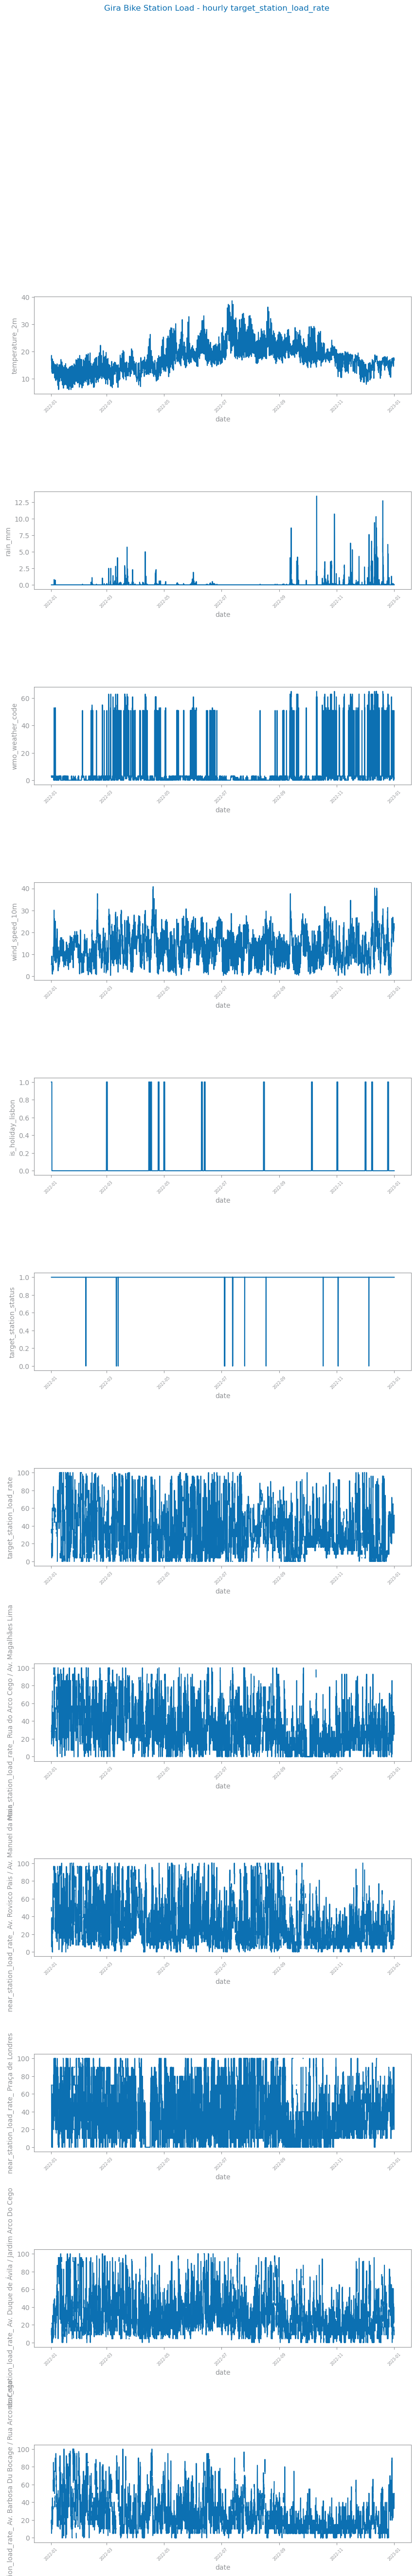

In [149]:
target = "target_station_load_rate"
data: DataFrame = df

print("Nr. Records = ", df.shape)
print("First timestamp", df.index[0])
print("Last timestamp", df.index[-1])

# Define a altura de cada subplot e o espaço entre eles
HEIGHT_PER_PLOT = 2.5
HSPACE = 1
# Plota os gráficos
plot_ts_multivariate_chart(df, title=f"{file_tag} - hourly {target}", hspace=HSPACE, height_per_plot=HEIGHT_PER_PLOT)

# Salva a figura
savefig(f"images/{file_tag}_profiling_multivariate_series.plot.png")

Nr. Records =  (8679, 12)
First timestamp 2022-01-01 12:00:00
Last timestamp 2022-12-31 23:00:00


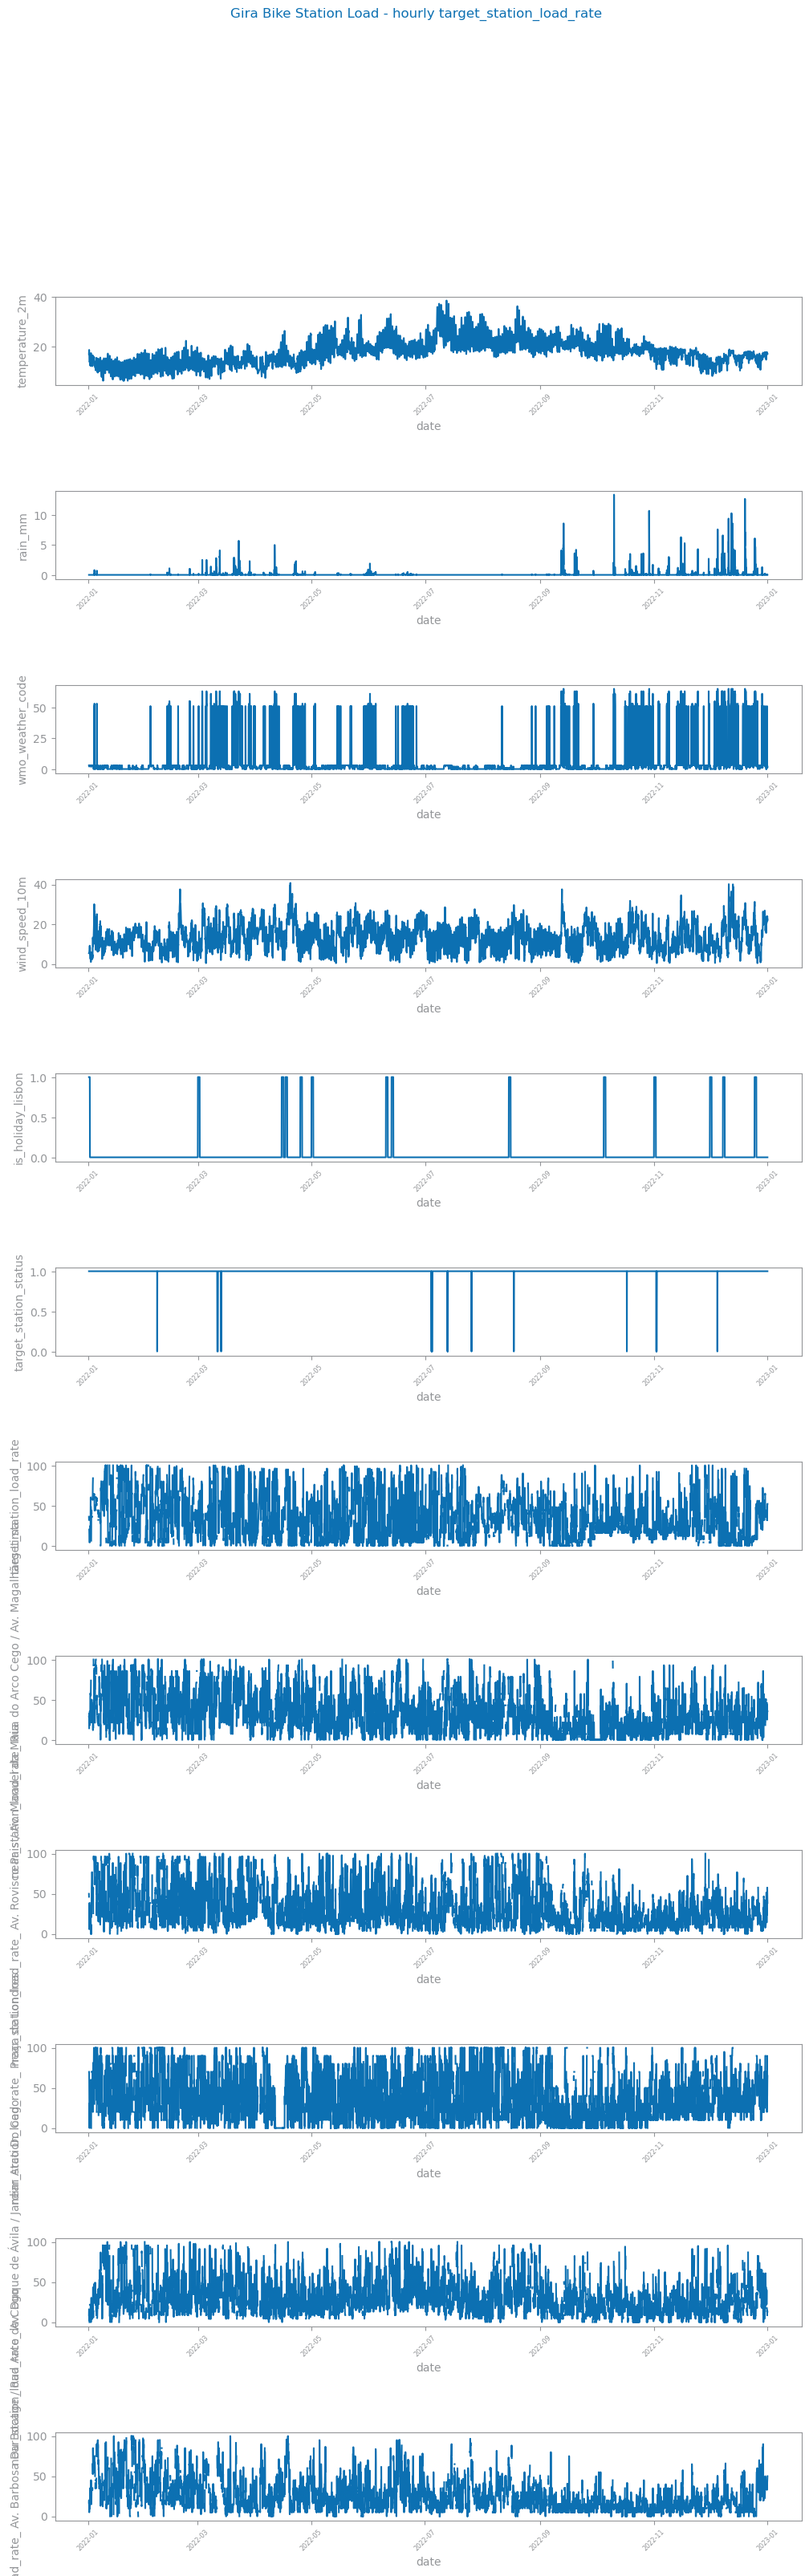

In [136]:

target = "target_station_load_rate"
data: DataFrame = df

print("Nr. Records = ", df.shape)
print("First timestamp", df.index[0])
print("Last timestamp", df.index[-1])

HEIGHT= 6

plot_ts_multivariate_chart(df, title = f"{file_tag} - hourly {target}", hspace=1.2)
savefig(f"images/{file_tag}_profiling_multivariate_series.plot.png")


#### Analysis for the report

## Time Series analysis

In [ ]:
series: Series = df['target_station_load_rate']

### Granularity

In [150]:
def derive_date_variables(df: DataFrame, date_columns: list[str]) -> DataFrame:
    for date_col in date_columns:
        if date_col == 'index' and isinstance(df.index, pd.DatetimeIndex):
            df['date'] = df.index  # Copy index into a 'date' column
        
        # Ensure we have the 'date' column now
        if 'date' in df.columns:
            df['year'] = df['date'].dt.year
            df['month'] = df['date'].dt.month
            df['quarter'] = df['date'].dt.quarter
            df['day'] = df['date'].dt.day
        else:
            raise ValueError("No valid date column found!")
    
    return df

Index(['temperature_2m', 'rain_mm', 'wmo_weather_code', 'wind_speed_10m',
       'is_holiday_lisbon', 'target_station_status',
       'target_station_load_rate',
       'near_station_load_rate_ Rua do Arco Cego / Av. Magalhães Lima',
       'near_station_load_rate_ Av. Rovisco Pais / Av. Manuel da Maia',
       'near_station_load_rate_ Praça de Londres',
       'near_station_load_rate_ Av. Duque de Ávila / Jardim Arco Do Cego',
       'near_station_load_rate_ Av. Barbosa Du Bocage / Rua Arco do Cego',
       'date', 'year', 'month', 'quarter', 'day'],
      dtype='object')


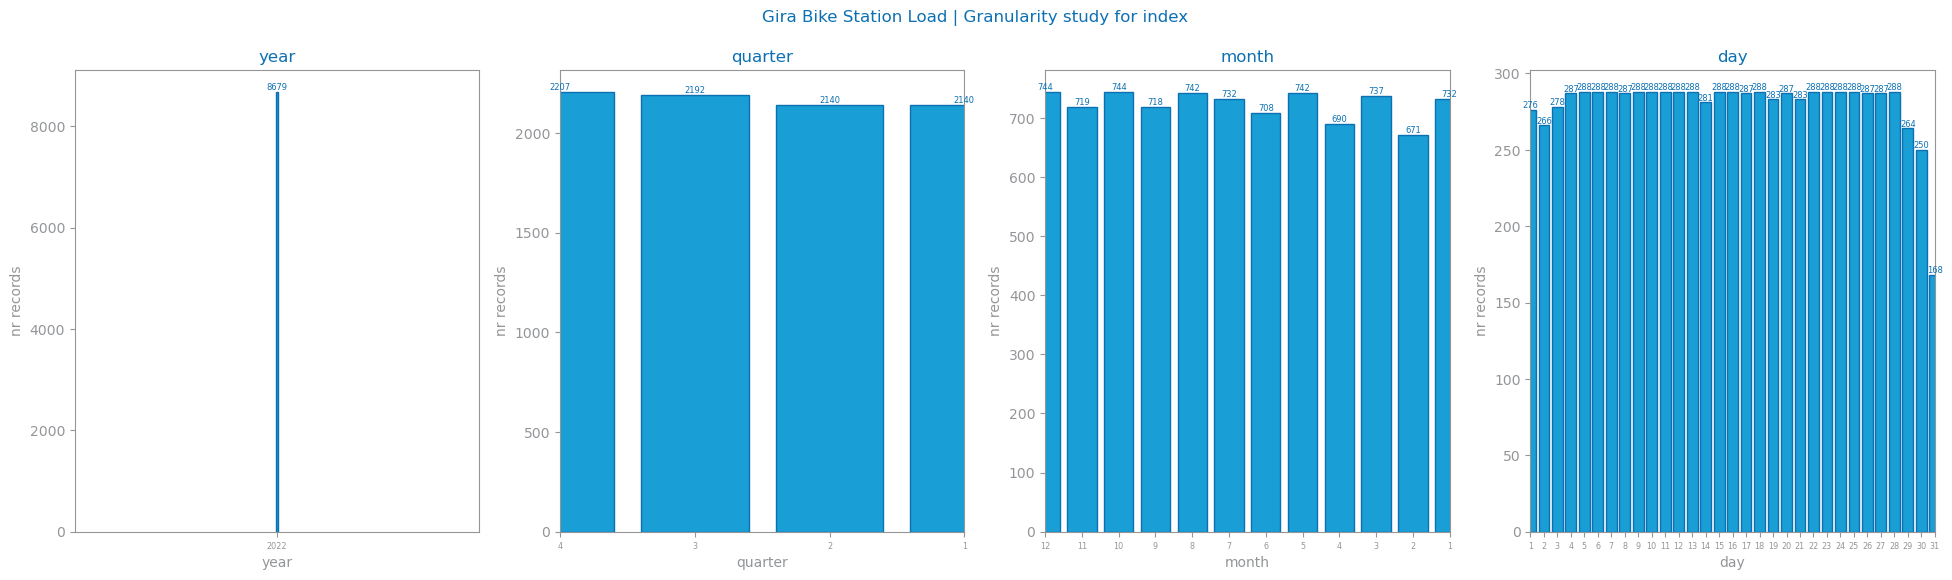

<Figure size 640x480 with 0 Axes>

In [152]:
from numpy import ndarray
from pandas import Series, read_csv
from matplotlib.figure import Figure
from matplotlib.pyplot import subplots, savefig, show
#from dslabs_functions import plot_bar_chart, HEIGHT
#get_variable_types

def analyse_date_granularity(train_df: DataFrame, var: str, levels: list[str]) -> ndarray:
    cols: int = len(levels)
    fig: Figure
    axs: ndarray
    fig, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    fig.suptitle(f"{file_tag} | Granularity study for {var}")

    for i in range(cols):
        # Directly use 'year', 'month', 'quarter', 'day' instead of 'index_year', 'index_quarter', etc.
        column_name = levels[i]  # Just use the level directly like 'year', 'quarter', 'month', 'day'
        
        if column_name not in train_df.columns:
            print(f"Warning: {column_name} column not found.")
            continue
        
        counts: Series[int] = train_df[column_name].value_counts()
        plot_bar_chart(
            counts.index.to_list(),
            counts.to_list(),
            ax=axs[0, i],
            title=levels[i],
            xlabel=levels[i],
            ylabel="nr records",
            percentage=False,
        )
    plt.show()
    return axs


train_df: DataFrame = df
variables_types: dict[str, list] = get_variable_types(train_df)

# Now call derive_date_variables after getting the date columns
train_df_ext: DataFrame = derive_date_variables(train_df, variables_types["date"])

# Check the columns to ensure everything is correct
print(train_df_ext.columns)  # Check if 'year', 'quarter', 'month', 'day' exist

for v_date in variables_types["date"]:
    analyse_date_granularity(train_df_ext, v_date, ["year", "quarter", "month", "day"])
    savefig(f"./{file_tag}_granularity_{v_date}.png")
    show()


#### Hourly aggregation (Original dataset)

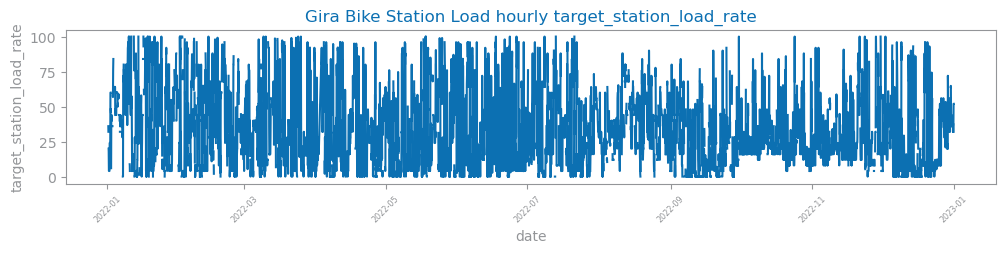

In [153]:
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_line_chart, HEIGHT


target = "target_station_load_rate"
data: DataFrame = df
series: Series = df[target]

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} hourly {target}",
)
show()

#### Daily aggregation

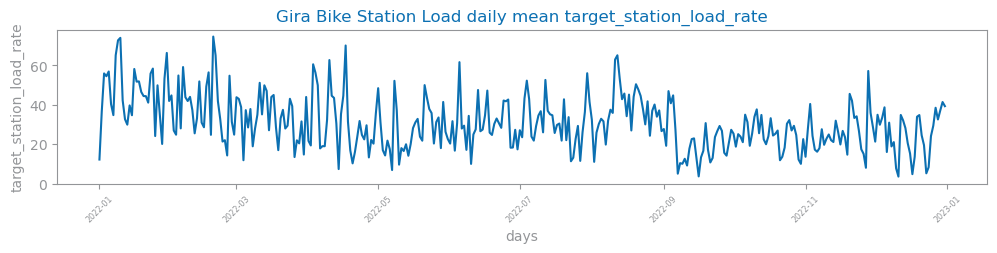

In [154]:
from pandas import Index, Period


def ts_aggregation_by(
    data: Series | DataFrame,
    gran_level: str = "D",
    agg_func: str = "mean",
) -> Series | DataFrame:
    df: Series | DataFrame = data.copy()
    index: Index[Period] = df.index.to_period(gran_level)
    df = df.groupby(by=index, dropna=True, sort=True).agg(agg_func)
    df.index.drop_duplicates()
    df.index = df.index.to_timestamp()

    return df


ss_days: Series = ts_aggregation_by(series, "D")
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    ss_days.index.to_list(),
    ss_days.to_list(),
    xlabel="days",
    ylabel=target,
    title=f"{file_tag} daily mean {target}",
)
show()

#### All time aggregations (Daily, weekly, monthly)

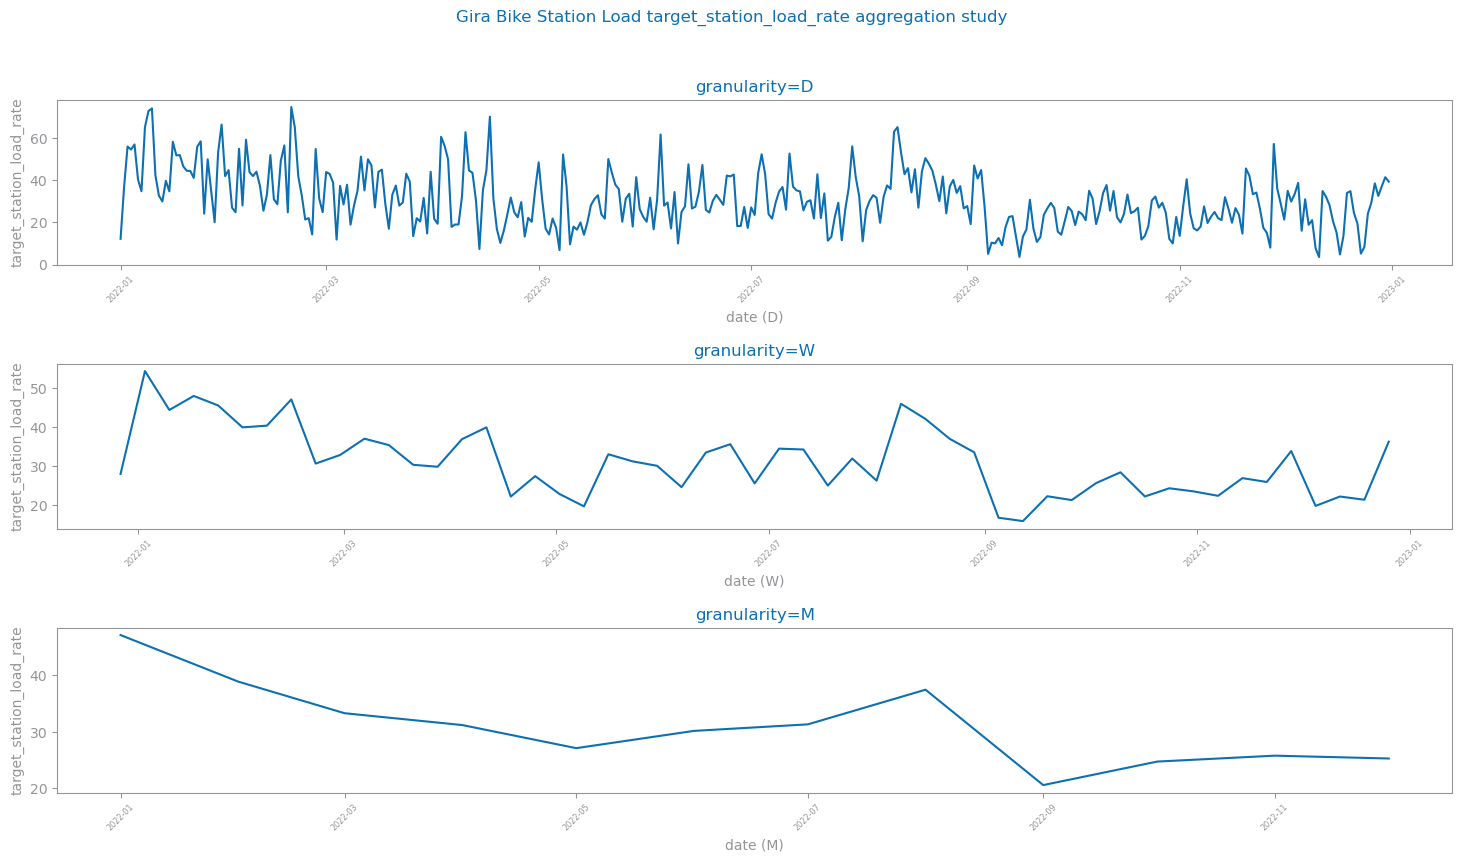

In [159]:
# Defina a altura desejada para a figura
HEIGHT = 6

# Lista de granularidades
grans: list[str] = ["D", "W", "M"]

# Cria os subplots com espaço ajustado entre eles
fig: Figure
axs: list[Axes]
fig, axs = subplots(
    len(grans), 1, 
    figsize=(3 * HEIGHT, HEIGHT / 2 * len(grans)), 
    gridspec_kw={'hspace': 0.6} 
)
fig.suptitle(f"{file_tag} {target} aggregation study")

# Plota cada subplot
for i in range(len(grans)):
    ss: Series = ts_aggregation_by(series, grans[i])
    plot_line_chart(
        ss.index.to_list(),
        ss.to_list(),
        ax=axs[i],
        xlabel=f"{ss.index.name} ({grans[i]})",
        ylabel=target,
        title=f"granularity={grans[i]}",
    )

# Exibe a figura
show()

#### Analysis for the report

### Distribution

In [ ]:
from matplotlib.pyplot import figure, show
from dslabs_functions import HEIGHT, plot_line_chart, ts_aggregation_by

ss_months: Series = ts_aggregation_by(series, gran_level="M", agg_func=sum)

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    ss_months.index.to_list(),
    ss_months.to_list(),
    xlabel="months",
    ylabel=target,
    title=f"{file_tag} monthly {target}",
)
show()

### Seasonality

### Stationary

# Save df from preprocessing into a csv file

# TO DO's
- See if we need to remove missing values in Target column before data profling an data transofrmation? - *** TO DO**
- Finish dataset description text - *** DONE**
- Get chart from univariate time series  - target column  *** DONE**
- Get chart from multivariate time series  - for all df columns through time  *** DONE**
    - Para isto ver codigo prof ds_labs e tentar replicar: - https://web.ist.utl.pt/~claudia.antunes/DSLabs/
- Do the rest of the part in João notebook after Series Analysis
    - estudar a estacionariedade da time series
    - Para isto ver codigo prof ds_labs e ver quais são os outros passos/estudos que ela faz no data profiling: - https://web.ist.utl.pt/~claudia.antunes/DSLabs/
- In paralel, read ppt from the course regarding time series and how to to data profling for Time Series:
    - title: Time Series
    - https://drive.google.com/file/d/1hg2e2iy3uYYtoV4u0OGaOf8VrLHKNVIz/view
- In paralel, continue to read the book, and apply R, - book: /Users/lourefra/Documents/Mercedes-benz.io/TRAINING/post graduation course IST - Data science/material de apoio/mod_3_previsao em series temporais/Forecasting_Principles_and_Practice.pdf
- Write parts of the Analyis to the report for univariate a multivariate plots of the time series
